In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from autoemulate.compare import AutoEmulate
from sklearn.metrics import r2_score

from autoemulate.experimental_design import LatinHypercube
from autoemulate.simulations.flow_functions import FlowProblem

import json

show_progress = False if os.getenv("JUPYTER_BOOK_BUILD", "false").lower() == "true" else True

In [ ]:
# Load the simulation input parameters and summary statistics

n_samples = 4096 ## compare with separate notebook 32768

sim_path = f'./outputs/simulations/output_{n_samples}_samples/'

# Load the simulation input parameters
input_params = pd.read_csv(os.path.join(sim_path, f'input_samples_{n_samples}.csv'))

# Load the boolean mask for failed simulations
with open(os.path.join(sim_path, 'bool_indices.json'), 'r') as f:
    bool_indices = json.load(f)

# Load the summary statistics
summary_stats = pd.read_csv(os.path.join(sim_path, f'simulations_summary.csv'))

In [ ]:
# Get column names for parameters up to 'T'
parameter_names = list(input_params.columns[:input_params.columns.get_loc('T') + 1])

input_params[parameter_names]

,ao.r,ao.c,art.r,art.c,ven.r,ven.c,av.r,mv.r,la.E_pas,la.E_act,la.v_ref,la.k_pas,lv.E_pas,lv.E_act,lv.v_ref,lv.k_pas,T
0,324.140512,0.429410,970.557289,2.593650,5.759509,141.391649,5.535208,3.645771,0.302181,0.614511,13.751520,0.074688,1.310537,3.983934,10.192377,0.040153,458.957450
1,213.211374,0.168363,1134.582900,3.092750,11.457833,81.051107,6.337772,5.927350,0.476733,0.449234,6.030600,0.032403,0.538215,2.789425,7.998957,0.014420,1177.644680
2,128.027561,0.373035,664.791603,1.807716,9.775524,110.934879,3.831676,4.690519,0.657067,0.244713,9.303856,0.023797,1.070499,3.257826,7.055576,0.027896,771.390037
3,287.120769,0.262023,1448.888220,3.761496,8.444797,167.239972,7.529157,2.905174,0.338195,0.522401,10.791995,0.054236,0.830979,2.014983,14.871574,0.027224,590.140139
4,261.317508,0.322630,1342.111306,4.190009,7.184780,154.969280,3.238999,4.237066,0.583734,0.372392,7.797148,0.048891,1.195902,2.575591,12.781972,0.020054,650.410479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,261.239524,0.187129,1611.013850,2.546204,12.242474,164.675291,6.580032,5.979305,0.620340,0.394455,11.701049,0.060913,1.497697,4.132858,5.213489,0.016088,680.774565
4092,287.203846,0.397812,1222.986903,2.955399,12.386278,177.532597,4.961748,3.214890,0.439200,0.496687,9.700770,0.070360,0.601389,3.194227,7.459513,0.013685,628.332031
4093,128.008471,0.209409,882.083549,3.451567,4.725247,100.399382,7.170582,5.525795,0.558643,0.324385,10.087454,0.034907,1.372125,2.031888,14.643495,0.041709,785.027915
4094,213.245499,0.303863,1537.292218,2.192902,7.507837,74.177440,3.677182,4.352275,0.519192,0.358919,14.626884,0.019013,0.767697,4.000712,10.567173,0.019480,1165.819979


In [ ]:
# Drop all the rows from input_params that correspond to entries in bool_indices
input_params = input_params.drop(bool_indices)

In [ ]:
Y = summary_stats['p_ao_mean'].values

In [ ]:
em = AutoEmulate()
em.setup(X = input_params[parameter_names], 
         y = Y, 
         models = ['gp'], ## Stick to gp
         n_jobs=-8)

,Values
Simulation input shape (X),"(4082, 17)"
Simulation output shape (y),"(4082,)"
Proportion of data for testing (test_set_size),0.2
Scale input data (scale),True
Scaler (scaler),StandardScaler
Scale output data (scale_output),True
Scaler output (scaler_output),StandardScaler
Do hyperparameter search (param_search),False
Reduce input dimensionality (reduce_dim),False
Reduce output dimensionality (reduce_dim_output),False


In [ ]:
best_model = em.compare()

Cross-validating:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
em.summarise_cv()

,preprocessing,model,short,fold,rmse,r2
0,None,GaussianProcess,gp,4,37.239990,0.569239
1,None,GaussianProcess,gp,3,38.438962,0.537251
2,None,GaussianProcess,gp,0,46.936406,0.431352
3,None,GaussianProcess,gp,1,42.341476,0.416607
4,None,GaussianProcess,gp,2,44.024968,0.411000


In [ ]:
gp = em.get_model("GaussianProcess")
em.evaluate(gp)
eval_df = em.evaluate(gp)

,model,short,preprocessing,rmse,r2
0,GaussianProcess,gp,None,39.3237,0.5631


In [ ]:
import os
save_folder = "outputs/emulator_r2/r2_values"
os.makedirs(save_folder, exist_ok=True)

r2_path = os.path.join(save_folder, f"r2_{n_samples}.txt")
with open(r2_path, "w") as f:
    f.write(str(r2))
print(f"Saved R² value ({r2:.4f}) to {r2_path}")

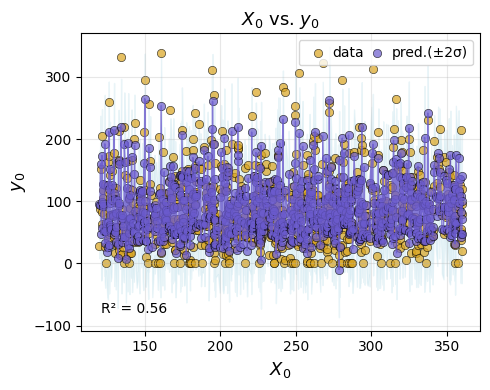

In [ ]:
em.plot_eval(gp)

In [ ]:
best_emulator = em.refit(gp)